# POCUS_videos CNN
<br>

#### Based on: Beginner’s guide to building Convolutional Neural Networks using TensorFlow’s Keras API in Python
---

### Import libraries

In [1]:
# Importing libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import PIL

### Set Directories

In [2]:
# Setting the paths to the train, validate, and test folders:
ROOT=os.path.join(os.getcwd(),'data') # this one must exist beforehand
train_path = os.path.join(ROOT,"train")
test_path = os.path.join(ROOT,"test")
valid_path = os.path.join(ROOT,"valid")
print('You are here: ', ROOT)

You are here: [omitted to protect privacy]\workspace\POCUS_videos\data


### "Standard-resize" images
#### Images must be cropped beforehand

In [4]:
images= os.listdir(os.path.join(ROOT,'data'))
image_array = np.array([PIL.Image.open(os.path.join(ROOT,'data',f), 'r').size for f in images])
image_array = np.array([PIL.Image.open(os.path.join(ROOT,'data',f), 'r').size for f in images])
mean=(int(np.mean(image_array[:,0])), int(np.mean(image_array[:,1])))
shutil.rmtree(os.path.join(ROOT,'data_resized'))
os.mkdir(os.path.join(ROOT,'data_resized'))
for current_image in images:
    img = PIL.Image.open(os.path.join(os.path.join(ROOT,'data',current_image)), 'r')
    img = img.resize((mean),PIL.Image.NEAREST)#, Image.ANTIALIAS)#####
    img.save(os.path.join(os.path.join(ROOT,'data_resized',current_image)))
print('Files resized to the mean size of the image set: ',mean)

Files resized to the mean size of the image set:  (723, 512)


### Reorganize Images
#### Craete Training, Test and Validation sets

In [21]:
train_perc= 0.75
test_perc= 0.15
valid_perc= 0.15
total_data_size= min(len(glob.glob('data_resized/cov*.jpg')),len(glob.glob('data_resized/reg*')))

# Organize data into train, valid, test directories
os.chdir(os.path.join(ROOT))
#if os.path.isdir('train/normal') is False: # check just one of them
#shutil.rmtree(os.path.join('train/normal'))
os.makedirs('train/normal')
shutil.rmtree(os.path.join('train/covid'))
os.makedirs('train/covid')
shutil.rmtree(os.path.join(ROOT,'valid/normal'))
os.makedirs('valid/normal')
shutil.rmtree(os.path.join(ROOT,'valid/covid'))
os.makedirs('valid/covid')
shutil.rmtree(os.path.join(ROOT,'test/normal'))
os.makedirs('test/normal')
shutil.rmtree(os.path.join(ROOT,'test/covid'))
os.makedirs('test/covid')

train_number= round(train_perc*total_data_size)
test_number= round(test_perc*total_data_size)
valid_number= round(valid_perc*total_data_size)
print(train_number, test_number, valid_number)

for i in random.sample(glob.glob('data_resized/cov*.jpg'), train_number):
    shutil.copy(i, 'train/covid')      
for i in random.sample(glob.glob('data_resized/reg*'), train_number):
    shutil.copy(i, 'train/normal')
for i in random.sample(glob.glob('data_resized/cov*'), valid_number):
    shutil.copy(i, 'valid/covid')        
for i in random.sample(glob.glob('data_resized/reg*'), valid_number):
    shutil.copy(i, 'valid/normal')
for i in random.sample(glob.glob('data_resized/cov*'), test_number):
    shutil.copy(i, 'test/covid')      
for i in random.sample(glob.glob('data_resized/reg*'), test_number):
    shutil.copy(i, 'test/normal')
print('Sorted into sets!')

os.chdir('../../') # two dirs up

52 10 10
Sorted into sets!


### Create batches

In [86]:
# Creating train, test and valid batches from the respective directories
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=mean, classes=['covid','normal'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=mean, classes=['covid', 'normal'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=mean, classes=['covid', 'normal'], batch_size=10, shuffle=False)

Found 104 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


### Visualize the image data:

In [87]:
# plot images in the form of a 1 by 10 grid and resize img to 20x20
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

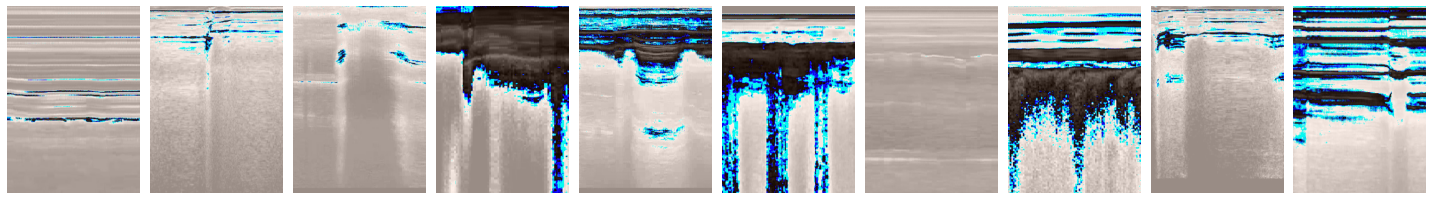

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [88]:
imgs, labels = next(train_batches)
plotImages(imgs)
print(labels)

### Generating the model architecture

In [89]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(mean[0],mean[1],3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax') # 2 classes for classification 
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 723, 512, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 361, 256, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 361, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 180, 128, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1474560)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2949122   
Total params: 2,968,514
Trainable params: 2,968,514
Non-trainable params: 0
____________________________________________

In [90]:
# Preparing the model for training
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [91]:
# Training and validating the model
# recall that we set batch_size = 10 during preprocessing
batch_size = 10 

model.fit(
    x = train_batches, 
    steps_per_epoch=train_batches.samples // batch_size, 
    epochs=10, 
    validation_data=valid_batches, 
    validation_steps=valid_batches.samples // batch_size,
    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 2 steps
Epoch 1/10
10/10 [==============================] - 262s 26s/step - loss: 255.6157 - accuracy: 0.6064 - val_loss: 122.7064 - val_accuracy: 0.6000
Epoch 2/10
10/10 [==============================] - 40s 4s/step - loss: 43.0257 - accuracy: 0.7447 - val_loss: 73.5606 - val_accuracy: 0.6000
Epoch 3/10
10/10 [==============================] - 74s 7s/step - loss: 75.1918 - accuracy: 0.6277 - val_loss: 26.1386 - val_accuracy: 0.6500
Epoch 4/10
10/10 [==============================] - 34s 3s/step - loss: 76.1573 - accuracy: 0.7340 - val_loss: 181.8581 - val_accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 36s 4s/step - loss: 127.3120 - accuracy: 0.6383 - val_loss: 47.2926 - val_accuracy: 0.7500
Epoch 6/10
10/10 [==============================] - 35s 4s/step - loss: 46.8772 - accuracy: 0.7447 - val_loss: 23.7580 - val_accuracy: 0.8000
Epoch 7/10
10/10 [==============================] -

In [92]:
# making predictions
predictions = model.predict(x = test_batches, verbose=0)

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
    else:
            print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[10  0]
 [ 2  8]]


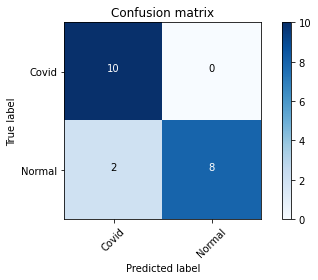

In [93]:
# confusion matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm, classes = ['Covid', 'Normal'])

---
### Predicitng new videos form HUFA

In [100]:
ROOT2= os.path.join(os.getcwd(),'data_HUFA')
ROOT2

'[omitted to protect privacy]\\workspace\\POCUS_videos\\data_HUFA'

In [102]:
images= os.listdir(os.path.join(ROOT2))
image_array = np.array([PIL.Image.open(os.path.join(ROOT2,f), 'r').size for f in images])
image_array = np.array([PIL.Image.open(os.path.join(ROOT2,f), 'r').size for f in images])
#mean=(int(np.mean(image_array[:,0])), int(np.mean(image_array[:,1])))
#shutil.rmtree(os.path.join(ROOT2,'data_resizedd'))
os.mkdir(os.path.join(ROOT2,'data_resized'))
for current_image in images:
    img = PIL.Image.open(os.path.join(os.path.join(ROOT2,current_image)), 'r')
    img = img.resize((mean),PIL.Image.NEAREST)#, Image.ANTIALIAS)#####
    img.save(os.path.join(os.path.join(ROOT2,'data_resized',current_image)))
print('Files resized to the mean size of the image set: ',mean)

Files resized to the mean size of the image set:  (723, 512)


In [109]:
# making predictions
data_folder= os.path.join(ROOT2, 'data_resized')
HUFA_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=data_folder, target_size=mean, classes=['covid', 'normal'], shuffle=False)

Found 8 images belonging to 2 classes.


In [110]:
predictions = model.predict(x = HUFA_batches, verbose=0)

In [111]:
predictions

array([[1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 9.2236442e-17],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.5933957e-35, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00]], dtype=float32)

Confusion matrix, without normalization
[[3 1]
 [0 4]]


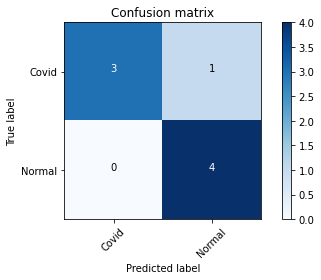

In [112]:
# confusion matrix
cm = confusion_matrix(y_true=HUFA_batches.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm, classes = ['Covid', 'Normal'])

---
based on [article](https://towardsdatascience.com/beginners-guide-to-building-convolutional-neural-networks-using-tensorflow-s-keras-api-in-python-6e8035e28238) <p>
Pablo [omitted to protect privacy]